In [1]:
from unet import unet_constructor as GUnet
import dataloader as dataloader
from loss import dice_loss, cross_entropy_loss, random_cross_entropy
import transforms as t
import torch.nn.functional as F
import torch
import torch.nn as nn
import torchvision.transforms as tt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import matplotlib.pyplot as plt
import pickle
import skimage.io as io
import os

writer = SummaryWriter()


In [2]:
data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.nul_crop(rate=1),
                                          t.random_crop([256, 256, 30]),
                                          t.random_rotate(),
                                          #t.random_affine()
                                          ],
                        image_transforms=[
                                          t.drop_channel(.8), 
                                          t.random_gamma((.8, 1.2)),
                                          t.random_intensity(),
                                          t.spekle(0.00001),
                                          t.clean_image(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )

val_data = dataloader.stack(path='./Data/train',
                        joint_transforms=[t.to_float(),
                                          t.reshape(),
                                          t.random_crop([512, 512, 30]),
                                          t.random_rotate(90),
                                          #t.random_affine
                                          ],
                        image_transforms=[
                                          #t.random_gamma((.8,1.2)),
                                          #t.spekle(),
                                          t.normalize([0.5, 0.5, 0.5, 0.5], [0.5, 0.5, 0.5, 0.5])
                                          ]
                        )



In [3]:
device = 'cuda:0'

test = GUnet(image_dimensions=3,
             in_channels=4,
             out_channels=1,
             feature_sizes=[16,32,64,128],
             kernel={'conv1': (5, 5, 2), 'conv2': (5, 5, 1)},
             upsample_kernel=(8, 8, 2),
             max_pool_kernel=(2, 2, 1),
             upsample_stride=(2, 2, 1),
             dilation=1,
             groups=2).to(device)


test = test.type(torch.float)

image, mask, pwl = data[0]

out = test.forward(image.float().to(device))
out_loss = dice_loss(out, mask.to(device))#, pwl.float().to('cuda'))



In [4]:
#test.load('May14_chris-MS-7C37_2.unet') # <- BEST YET
test.load('May28_chris-MS-7C37_2.unet')
test.cuda()
test.train()
print('Yeet')

Yeet


In [ ]:
test

In [5]:
epoch = 0 
k = 0
running_loss = 0
device = 'cuda:0'                 
upsample_stride=2,


losses_dice=[]
avg_losses_dice = []
losses_BCE=[]
avg_losses_BCE = []



In [6]:
lr = 1e-8
gamma = .75

optimizer = torch.optim.Adam(test.parameters(), lr = lr)
#optimizer = torch.optim.SGD(test.parameters(), lr=lr, momentum=.99, nesterov=True)

scheduler_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=gamma)
scheduler_2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=100)


In [7]:
while True:  # loop over the dataset multiple times
    epoch_loss_dice=[]
    epoch_loss_BCE=[]
    epoch_loss_joint=[]
    for i in range(len(data)):
        image, mask, pwl  = data[i]
        
        if torch.isnan(image.float()).any():
            raise ValueError
        if torch.isnan(mask.float()).any():
            raise ValueError('MASK')
        if torch.isnan(pwl.float()).any():
            raise ValueError('PWL')
        if torch.isinf(image.float()).any():
            raise ValueError
        if torch.isinf(mask.float()).any():
            raise ValueError('MASK')
        if torch.isinf(pwl.float()).any():
            raise ValueError('PWL')

        optimizer.zero_grad()
        out = test(image.float().to('cuda'))


        #out_loss = ((np.cos(2*np.pi * (epoch/100))+1)/4 + .2) * cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda'), 5) +\
        #           dice_loss(out, mask.to('cuda'))
        out_loss = cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda')) +\
                   1.3 * dice_loss(out, mask.to('cuda'))
        
        if torch.isnan(out_loss):
            print(cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda')))
            print(dice_loss(out, mask.to('cuda')))
            print(torch.isnan(mask.float()).any(), torch.isnan(image.float().any()), torch.isnan(pwl.float()).any())
            print(out.shape)
            raise ValueError
        
        del out
        
        epoch_loss_joint.append(out_loss.item())
        
        print(f'\r\033[32mEpoch: \033[0m{epoch} |',end='')
        print(f' JOINT |', end='')
        print(f' {i} |',end='')
        print(f' \033[35mPOL: \033[0m{str(running_loss)[0:8]} -->', end='')
        print(f' \033[35mOL: \033[0m{str(out_loss.item())[0:8]}', end='')

        out_loss.backward()
        optimizer.step()
        

        running_loss = out_loss.item()
        
        del out_loss, mask, pwl 
        
#         if epoch+1 % 150 == 0:
#             scheduler_1.step() 
            
    #torch.cuda.empty_cache()
    
    to_tb = np.array(epoch_loss_joint).sum()/len(epoch_loss_joint)
    writer.add_scalar('Cyclic Joint Loss Train', to_tb, epoch)
    epoch += 1




Epoch: 34 | JOINT | 5 | POL: 1.171617 --> OL: 1.027906

KeyboardInterrupt: 

In [ ]:
        if torch.isnan(out_loss):
            print(cross_entropy_loss(out, mask.to('cuda'), pwl.to('cuda')))
            print(dice_loss(out, mask.to('cuda')))
            print(torch.isinf(mask.float()).any(), torch.isinf(image.float()).any(), torch.isinf(pwl.float()).any())
            print(torch.isnan(mask.float()).any(), torch.isnan(image.float()).any(), torch.isnan(pwl.float()).any())
            print(torch.isnan(out).sum(), torch.isinf(out).any())
            


In [ ]:
torch.cuda.empty_cache()

In [ ]:
test.save('May28_chris-MS-7C37_2.unet')

In [8]:
image, mask, pwl  = val_data[1]
#test.eval()
#test.cpu()
with torch.no_grad(): 
    out = test(image.float().cuda())


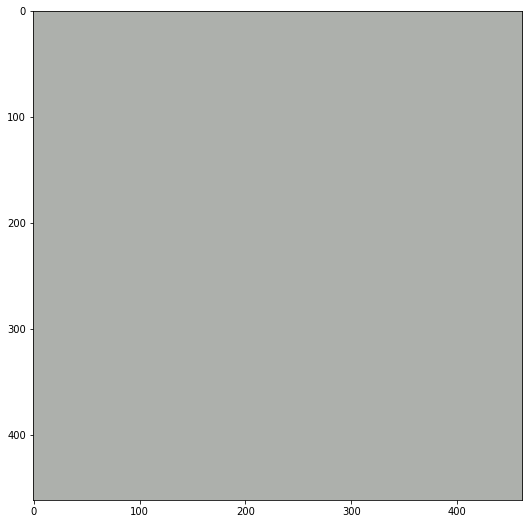

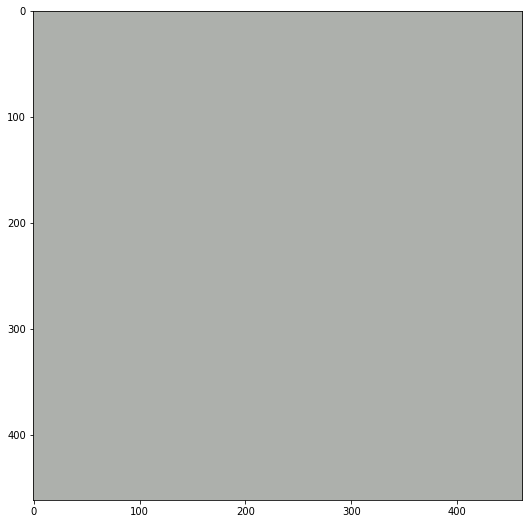

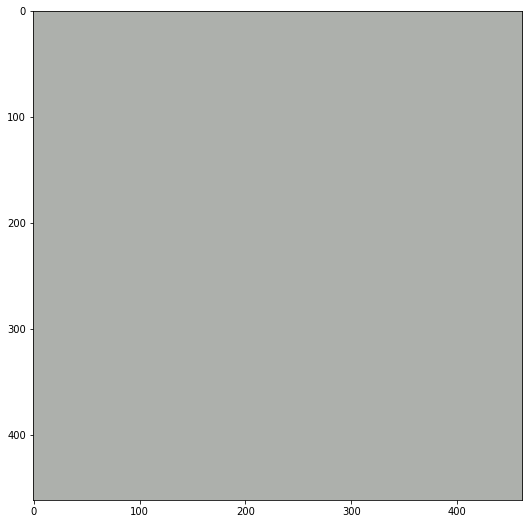

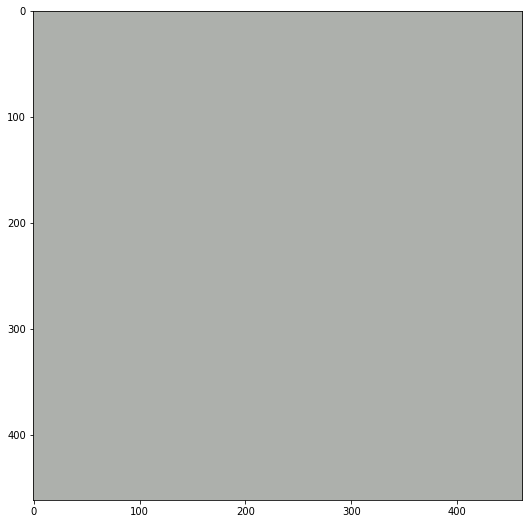

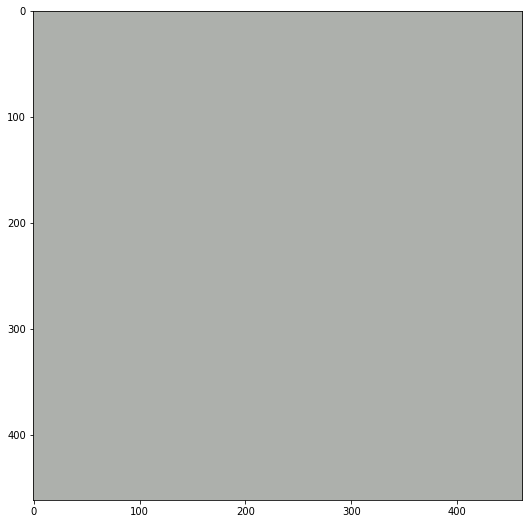

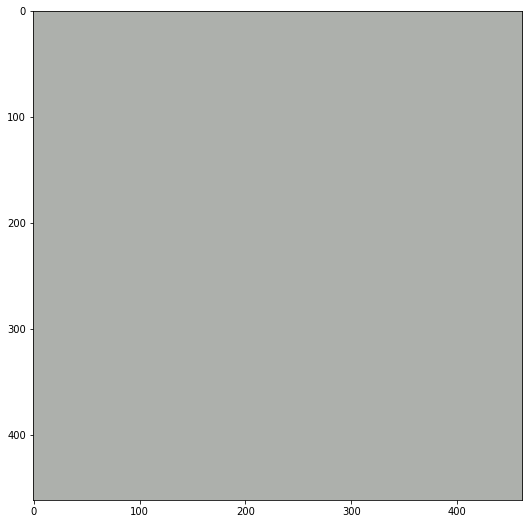

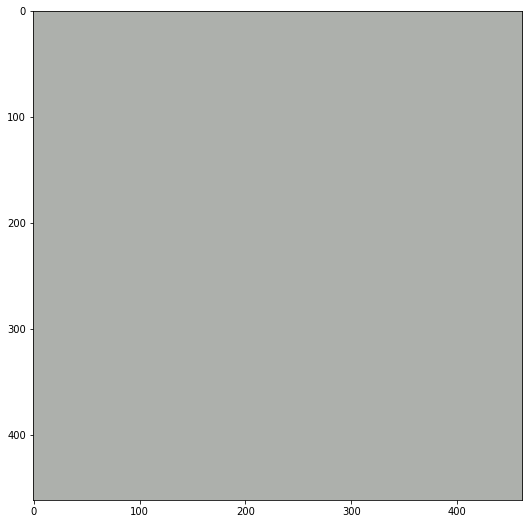

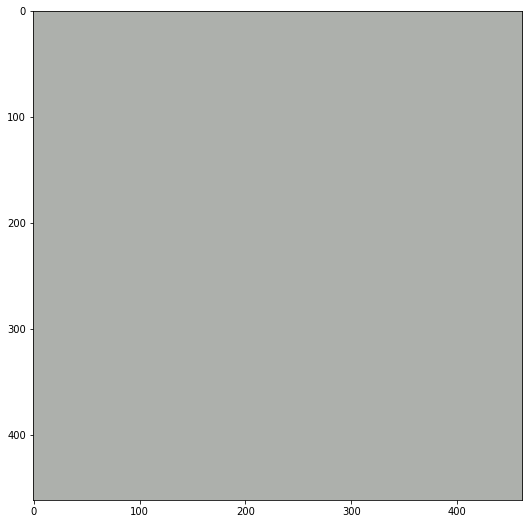

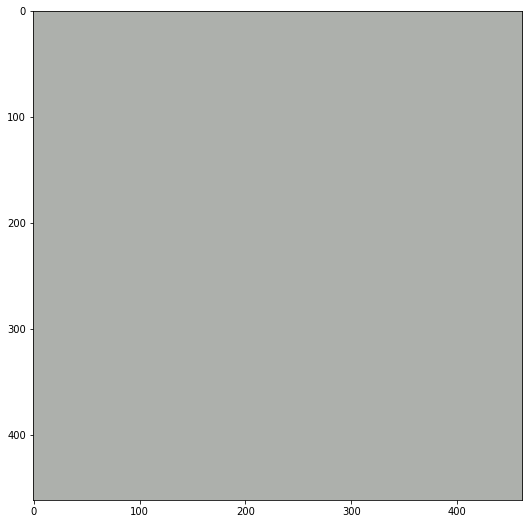

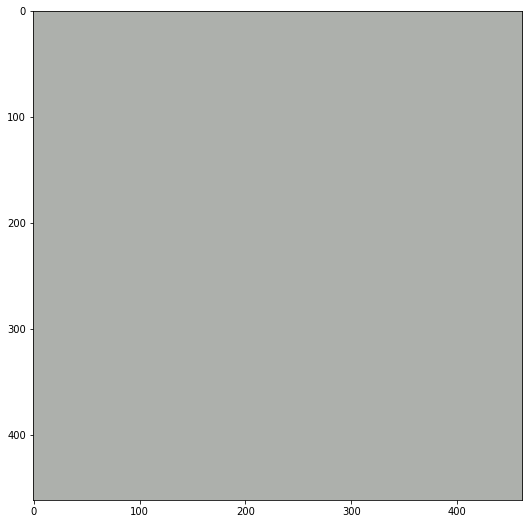

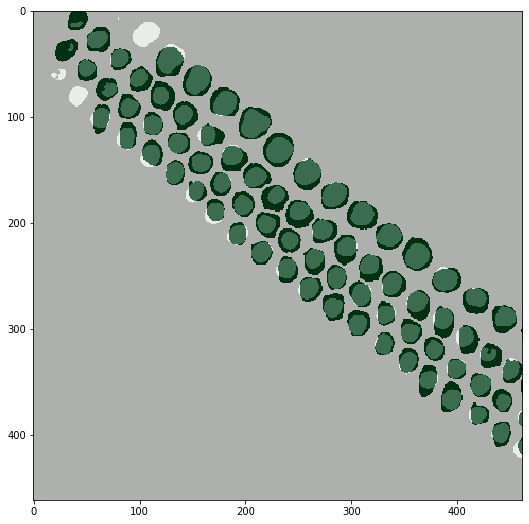

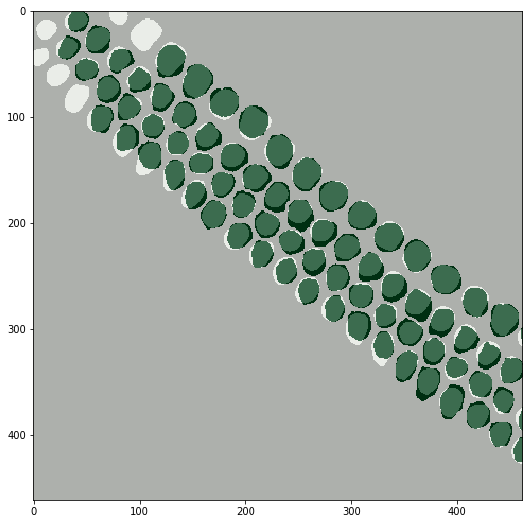

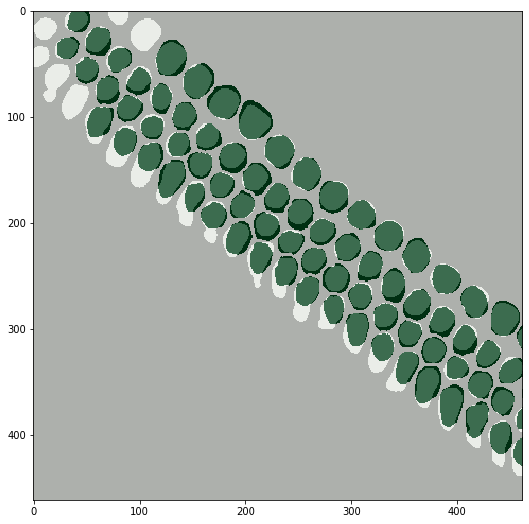

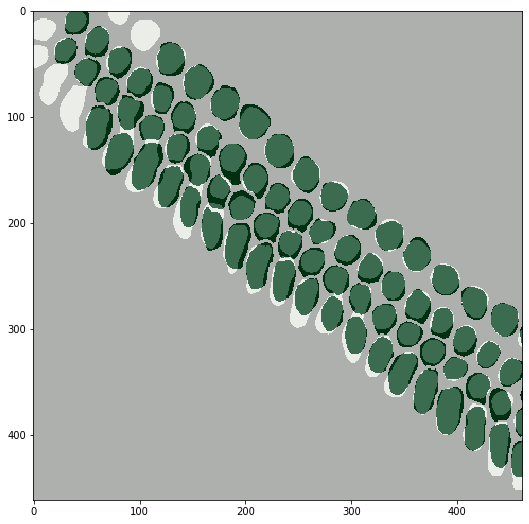

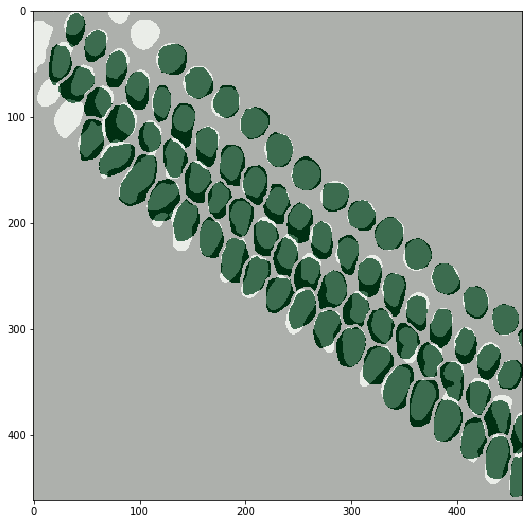

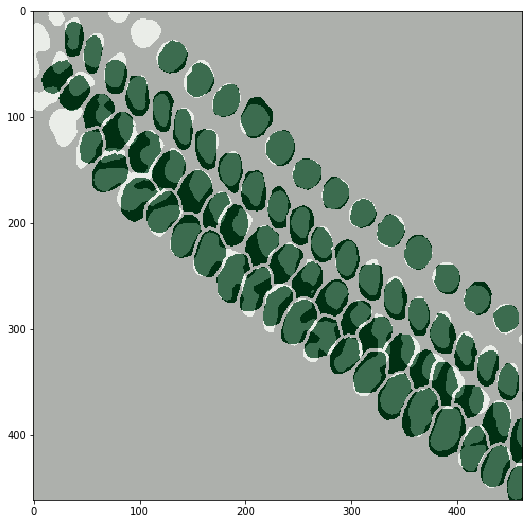

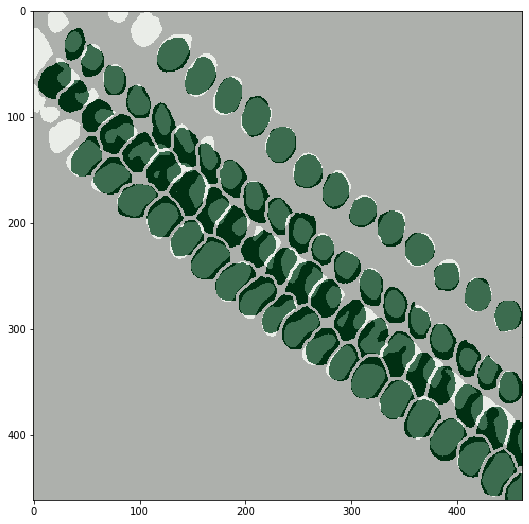

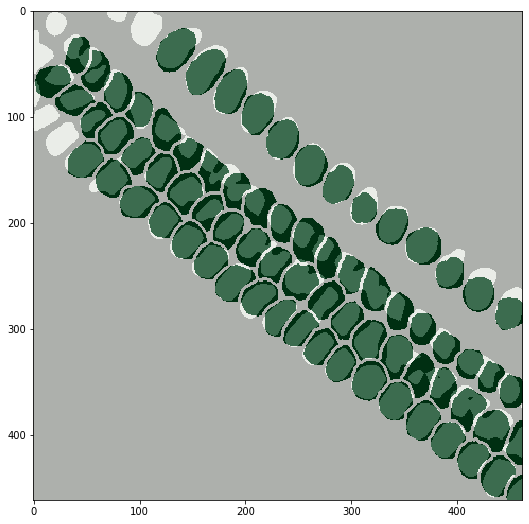

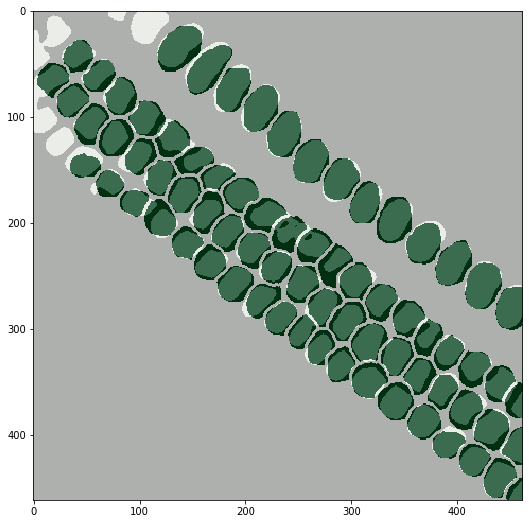

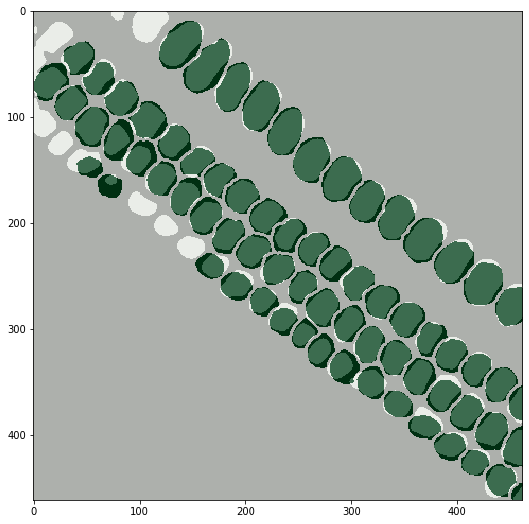

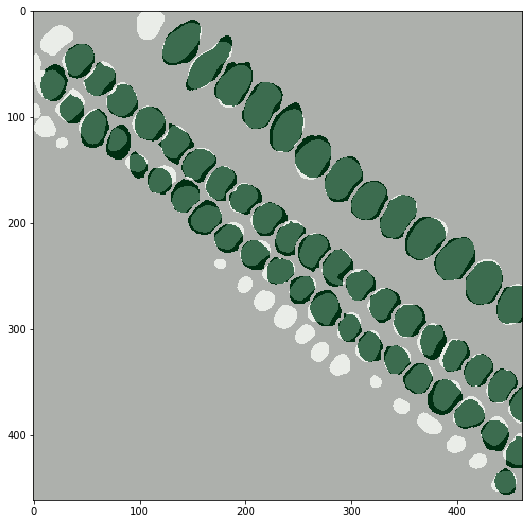

IndexError: index 21 is out of bounds for dimension 4 with size 21

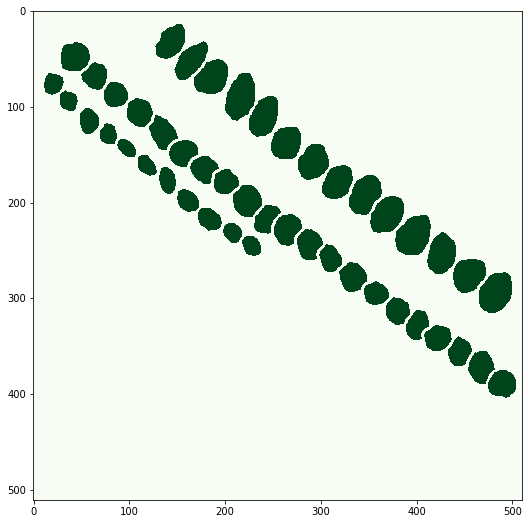

In [9]:
pred = F.sigmoid(out) > .5
for i in range(image.shape[-1]):
    plt.figure(figsize=(9,9))
    #plt.imshow(image[0,[0,2,1],:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    #plt.imshow(image[0,0:3,:,:,i].float().transpose(0,1).transpose(1,2)*.5 + .5)
    plt.imshow(mask[0,0,:,:,i].float(), cmap = 'Greens')
    plt.imshow(pred[0,0,:,:,i].cpu().detach().numpy(), cmap=plt.cm.nipy_spectral,alpha=.3)
    plt.show()


In [ ]:
pwl.float().min()

In [ ]:
io.imsave('overlap.tif', pred.cpu().squeeze(0).transpose(0,3).float().numpy())

In [ ]:
n.shape

In [ ]:
image.float()